## Librerias y Dataset

Lo primero que hacemos es importar el data set y las múltiples librerías que vamos está utilizando durante este proceso.

In [244]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
sns.set()

In [245]:
data = pd.read_csv("house_train_raw.csv")
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## Analisis exploratorio de los datos

In [268]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 251 entries, Id to SaleCondition_Partial
dtypes: float64(1), int64(35), uint8(215)
memory usage: 717.3 KB


In [246]:
# Borramos las columnas que tengan mas de 3% de datos nulos
data.drop(list(data.columns[data.isna().sum()>50]),axis=1, inplace=True)

# En las filas con menos del 3% de datos nulos, reemplazamos esos valores por el promedio
data.fillna(value=data.mean(),inplace=True)

# Funcion para crear columnas numericas de variables dummys
def createDummies(df, var_name):
    dummy = pd.get_dummies(df[var_name], prefix=var_name)
    df = df.drop(var_name, axis = 1)
    df = pd.concat([df, dummy ], axis = 1)
    return df

# Con un for interamos las columnas categoricas y las reemplazamos por numericas
for col in data.columns:
    if type(data[col][0])==str:
        data = createDummies(data, col)


# Creamos una matriz de correlacion para desde ahi elegir las mejores columnas
# No graficamos la matriz de correlacion con headmap porque son 251. Vamos, que es un poco obvio
corr = data.corr() 

C:\Users\Nacho\AppData\Local\Temp/ipykernel_16960/1663708321.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.fillna(value=data.mean(),inplace=True)


A la hora de hacer un análisis de los datos nos damos cuenta que hay varias columnas con valores nulos por lo tanto tomamos la decisión de las columnas que tengan un más de 3% de valores nulos serán eliminadas.

También con la createDummies manejaremos y reemplazaremos las columnas de variables categóricas por variables numéricas correspondientes, es decir si la variable categórica tienen 4 tipos distintos se crearán sólo 3 columnas sobre esa categoría.

Al final creamos una matriz de correlación para analizar qué variables son más dependientes de la variable de precio.

## Regresion Lineal

Lo primero que vamos a hacer es aplicar un modelo de regresión lineal.

Pero no vamos a tomar todas las columnas, sino que vamos a seleccionar. Sobre qué cantidad de columnas el modelo de regresión lineal nos arroja el mejor resultado. Por lo tanto hemos hecho en un rango los diferentes valores de correlación y de acuerdo a los valores de correlación nos vamos a quedar con más o menos columnas. 

También en el mismo proceso de interacción vamos a aplicar el StandardScaler para normalizar los datos y ponerlos sobre una media 0 y una desviacion 1.

In [247]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

# Rango de valores de correlacion sobre los cuales obtendremos la cantidad optima de columnas para trabajar
rango=[0.01,0.05,0.1,0.2,0.5,0.7]
for i in rango:
    try:
        # En esta instruccion creamos un data set solo con las columnas donde la correlacion positiva sea mayor a i o la correlacion negativa sea menor que i
        data2 = pd.concat([data[list(corr[corr.loc["SalePrice",:]>i].index)],data[list(corr[corr.loc["SalePrice",:]<-i].index)]], axis=1)
        data2

        # Convertimos el dataset data en dos partes X donde estan todas las columnas salvo el precio e Y donde solo esta el precio de la casa
        Y = data2.loc[:,"SalePrice"]
        X = data2
        X.drop("SalePrice", axis=1, inplace=True)
        columnas = X.columns
        X = X.values

        # Aplicamos un StandardScaler para escalar los valores numericos de las columnas con un valor de media 0 y de desviacion 1
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
        X = pd.DataFrame(X, columns=columnas)


        # Para optimizar tiempos no realizaremos la validacion cruzada en esta seccion (ademas que podemos llegar a tener problemas con predicciones negativas)
        # Por lo tanto separaremos a X e Y en X_train, X_val, Y_train, Y_val para poder darle mas relevancia a los valores que obtengamos de mean_squared_log_error
        X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.3,random_state=0)
        reg = LinearRegression().fit(X_train, Y_train)
        prediccion = list(reg.predict(X_val))

        # Calculamos el valor del error
        print("MSLE test",round(mean_squared_log_error(Y_val, reg.predict(X_val), squared=False),5), "con valor de ",i)
        print("\n")
    except:
        print(f"no hay columnas para ese valor")

no hay columnas para ese valor
MSLE test 0.16226 con valor de  0.05


MSLE test 0.15632 con valor de  0.1


MSLE test 0.1632 con valor de  0.2


MSLE test 0.18127 con valor de  0.5


MSLE test 0.22669 con valor de  0.7




Mejor valor para  0.1 de 0.15632

In [248]:
# Realizamos el mismo trabajo anterior con data, X e Y pero esta vez con el valor final de i

data2 = pd.concat([data[list(corr[corr.loc["SalePrice",:]>0.1].index)],data[list(corr[corr.loc["SalePrice",:]<-0.1].index)]], axis=1)
data2
Y = data2.loc[:,"SalePrice"]

X = data2
X.drop("SalePrice", axis=1, inplace=True)
columnas = X.columns
X = X.values

scaler = StandardScaler()
scaler.fit(X)

X = scaler.transform(X)
X = pd.DataFrame(X, columns=columnas)

In [249]:
# Validacion cruzada de 5 cortes
scores =  cross_validate(
            estimator = reg,
            X         = X,
            y         = Y,
            scoring   =('neg_mean_squared_log_error'),
            cv        = 5
            )

# Como la funcion scores trabaje direcamente con el MSLE para poder obtener el RMSLE realizamos la raiz con la funcion math
math.sqrt(-1*scores["test_score"].mean())

0.6603014582128505

Obteniendo el valor de 0.1 como mejor valor de correlación. Realizamo la validación cruzada. Obteniendo root_mean_squared_log_erro 0,66.
Entendiendo que hemos encontrado un buen modelo. Pero que pueden mejorarse ampliamente decidimos utilizar árboles de decisión para perfeccionar el modelo.

## Arboles de Desicion

In [253]:
# Arbol de desicion por defecto con validacion cruzada de 5 cortes
tree= DecisionTreeRegressor()
scores =  cross_validate(
            estimator = tree,
            X         = X,
            y         = Y,
            scoring   =('neg_mean_squared_log_error'),
            cv        = 5
            )
math.sqrt(-1*scores["test_score"].mean())

0.20941754346593708

Utilizando los valores por defecto del árbol de decisión. Y una validación cruzada de 5 separaciones obtenemos una mejora del error sustancial que lo lleva a 0,20.

Aún así consideramos que el modelo puede mejorarse ampliamente todavía. Por lo que decidimos hacer un recorrido sobre muchos modelos y sobre muchos parámetros GridSearchCV. De esta forma en contrar el mejor modelo y acercarnos al los mejores parámetros para dicha situación.

## Eleccion de modelo

Para este caso probaremos los modelos de Regresion Lineal, SVR, Arbol de desicion, Random Forest, Ridge, GradientBoostingRegressor.
Para cada modelo hemos lesionado 3 parámetros aproximadamente. Para ser testiados y de esta forma acercarnos a los mejores valores.

In [259]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import accuracy_score

In [262]:
# Lista de paremetros en orden de sus modelos correspondientes
params=[{'fit_intercept':(True,False)},
             {'n_estimators':[100,300,200],
             'max_depth':[6,10,15]},
             {'alpha': [0.1,300,10,500,1000,200]},
    {'kernel':('linear', 'poly'),
             'C':[100,200,400],
             'epsilon':[10,100],
     'gamma':('scale', 'auto')},
     {"n_estimators":[100,300,500],
     "learning_rate":[0.05,0.1,0.5]}]

LR = LinearRegression(copy_X=True)
SaVR = SVR()
RFR = RandomForestRegressor(random_state=False)
RM = Ridge(random_state=False)
gdb = GradientBoostingRegressor()

models=[LR,RFR,RM,SaVR,gdb]

Para este caso y por motivos de no poder utilizar una validación cruzada por tener valores negativos en las predicciones y no poder hacer las modificaciones correspondientes. Decido realizar el análisis con el X y el Y. Las predicciones respecto a la predicción y los valores en Y. Sabiendo que esto no me entregará los mejores valores o valores reales. Pero considerando que solamente sera para elegir el modelo más adecuado para trabajar.

In [263]:
# Realizamos un for con un zip para iterar a la vez los modelos con los hiperametros

for model,param in zip(models,params):
    print('Model is ',model)
    for i in range (5,15):

        # Realizamos el GridSearchCV con cada modelo y con diferentes secciones del dataset para obtener mas fiabilidad en los valores
        # Lo entrenamos y predecimos los resultados para despues compararlos con el dataset Y obteniendo el RMSLE
        
        GridSearchModel = GridSearchCV(model,param, cv = i,return_train_score=True, n_jobs=5)
        GridSearchModel.fit(X, Y)
        VD_predict=GridSearchModel.predict(X)
        print(VD_predict.shape)

        # Utilizamos esta instruccion para evitar problemas con predicciones negativas que puedan afectar el desempeño del modelo o que no permitan calcular el RMSLE
        VD_predict[VD_predict<0]=0
        
        MSEValue = mean_squared_log_error(Y, VD_predict, squared=False) 
        
        sorted(GridSearchModel.cv_results_.keys())
        print('CV = ',i)
        print('Best Score is :', GridSearchModel.best_score_)
        print('Best Parameters are :', GridSearchModel.best_params_)
        print('Mean_squared__log_error = ',MSEValue)
        print('---------------------------')
    print('\t\t**********************************************************')

Model is  LinearRegression()
(1460,)
CV =  5
Best Score is : -7294.35043488121
Best Parameters are : {'fit_intercept': False}
Mean_squared__log_error =  8.980916920617835
---------------------------
(1460,)
CV =  6
Best Score is : -7560.681226720116
Best Parameters are : {'fit_intercept': False}
Mean_squared__log_error =  8.980916920617835
---------------------------
(1460,)
CV =  7
Best Score is : -7975.69079117543
Best Parameters are : {'fit_intercept': False}
Mean_squared__log_error =  8.980916920617835
---------------------------
(1460,)
CV =  8
Best Score is : -7874.2892411477205
Best Parameters are : {'fit_intercept': False}
Mean_squared__log_error =  8.980916920617835
---------------------------
(1460,)
CV =  9
Best Score is : -7689.487161541923
Best Parameters are : {'fit_intercept': False}
Mean_squared__log_error =  8.980916920617835
---------------------------
(1460,)
CV =  10
Best Score is : -7609.422986422878
Best Parameters are : {'fit_intercept': False}
Mean_squared__log_

Después de todo el proceso y observando los valores de error que obtenemos tomo como los mejores a los del árbol de decisión y a los del Gradient Boosting Regressor. Por los similares que son ambos modelos y que uno está basado en el otro. Consideró que el modelo más robusto para trabajar es el modelo de Gradient Boosting Regressor. Y por lo tanto pasó a trabajar con ese modelo y de esta forma optimizar sus hiper parámetros.

## Gradient Boosting Regressor y sus hiperparaemtros

estimador:  1
RMSLE de la validacion cruzada:  0.37318400866261797
RMSLE de la predict:  0.36826314015736183
estimador:  26
RMSLE de la validacion cruzada:  0.1710573981490915
RMSLE de la predict:  0.03495131444101293
estimador:  51
RMSLE de la validacion cruzada:  0.16780518276195452
RMSLE de la predict:  0.0033676619760493014
estimador:  76
RMSLE de la validacion cruzada:  0.1675868380605624
RMSLE de la predict:  0.001094228794284741
estimador:  101
RMSLE de la validacion cruzada:  0.16757112549373399
RMSLE de la predict:  0.0010397820432844233
estimador:  126
RMSLE de la validacion cruzada:  0.16757130760475544
RMSLE de la predict:  0.0010381209555302576
estimador:  151
RMSLE de la validacion cruzada:  0.16757168130316838
RMSLE de la predict:  0.00103808123626107
estimador:  176
RMSLE de la validacion cruzada:  0.16757171787450972
RMSLE de la predict:  0.0010380768788205675
estimador:  201
RMSLE de la validacion cruzada:  0.16757172535849607
RMSLE de la predict:  0.00103807640824492

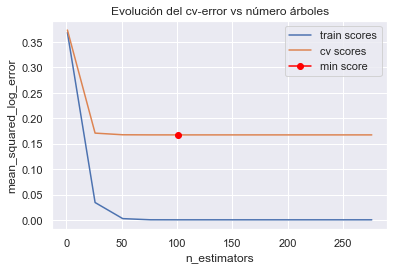

In [264]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 300, 25)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
        
        # Creamos el modelo con los valores de cada iteracion
        print("estimador: ",n_estimators)
        modelo = GradientBoostingRegressor(
                        n_estimators = n_estimators,
                        loss         = 'squared_error',
                        max_features = 'auto',
                        max_depth    = 30,
                        min_samples_split = 6,
                        random_state = 0
                )

        # Hacemos la validacion cruzada
        scores =  cross_validate(
                        estimator = modelo,
                        X         = X,
                        y         = Y,
                        scoring   =('neg_mean_squared_log_error'),
                        cv        = 5
                )
        
        # Se agregan los scores de cross_val_score() y se pasa a positivo
        cv_scores.append(math.sqrt(-1*scores["test_score"].mean()))
        print("RMSLE de la validacion cruzada: ",math.sqrt(-1*scores["test_score"].mean()))

        # Entrenamos el modelo y generamos la prediccion, para despues calcular el RMSLE de la prediccion
        modelo.fit(X, Y)
        predicciones = modelo.predict(X = X)
        rmse = mean_squared_log_error(
                y_true  = Y,
                y_pred  = predicciones,
                squared = False
                )
        train_scores.append(rmse)
        print("RMSLE de la predict: ",rmse)


# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("mean_squared_log_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

En este casi realizando una interacion entre diferentes valores de cantidad de estimaciones. Para que el modelo consiga sus mejores resultados después de varios intentos. Concluyó que el mejor valor es de 100 estimaciones. Como indica el grafico

En esta sección realizamos el mismo proceso que en la sección anterior pero trabajando con la tasa de aprendizaje. Por lo tanto realizaremos en este caso 2 interacciones para que con valores de cantidad de estimaciones cercanos a los anteiores y con diferentes valores de de ratio de aprendizaje. Consigamos el mejor modelo posible para esta situación.

estimador:  50  learning_rate:  0.2
RMSLE de la validacion cruzada:  0.16626925389074315
RMSLE de la predict:  0.0010408923307353942
estimador:  100  learning_rate:  0.2
RMSLE de la validacion cruzada:  0.16626936829227668
RMSLE de la predict:  0.00103807718701125
estimador:  150  learning_rate:  0.2
RMSLE de la validacion cruzada:  0.1662693642804144
RMSLE de la predict:  0.0010380763993589437
estimador:  50  learning_rate:  0.21
RMSLE de la validacion cruzada:  0.16652412444898035
RMSLE de la predict:  0.00106237964435529
estimador:  100  learning_rate:  0.21
RMSLE de la validacion cruzada:  0.16652448051909183
RMSLE de la predict:  0.0010380763999765035
estimador:  150  learning_rate:  0.21
RMSLE de la validacion cruzada:  0.16652447331743503
RMSLE de la predict:  0.0010380763977931918
estimador:  50  learning_rate:  0.22
RMSLE de la validacion cruzada:  0.16737832233245895
RMSLE de la predict:  0.001044909210904069
estimador:  100  learning_rate:  0.22
RMSLE de la validacion cruzad

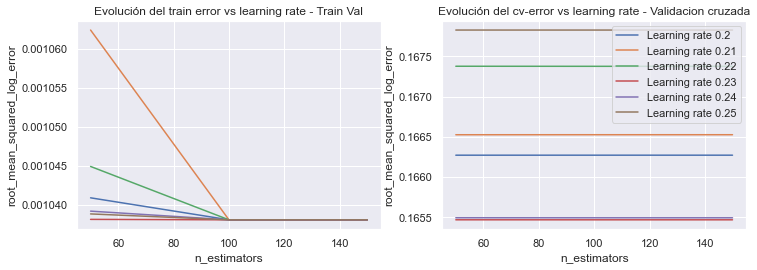

In [265]:
resultados = {}

# Valores evaluados
learning_rates = [0.2,0.21,0.22,0.23,0.24,0.25]
n_estimators   = [50, 100, 150]


# Bucle para entrenar un modelo con cada combinacion de  learning_rate y n_estimator 
# y extraer su error de entrenamiento y k-cross-validation.
for learning_rate in learning_rates:
    train_scores = []
    cv_scores    = []
    
    for n_estimator in n_estimators:
        
        print("estimador: ",n_estimator, " learning_rate: ",learning_rate)
        
        # Creamos el modelo con los valores de cada iteracion
        modelo = GradientBoostingRegressor(
                        n_estimators = n_estimator,
                        learning_rate = learning_rate,
                        loss         = 'squared_error',
                        max_features = 'auto',
                        max_depth    = 30,
                        min_samples_split = 6,
                        random_state = 0
                )

        # Hacemos la validacion cruzada para obtener RMSLE de la validacion cruzada
        scores =  cross_validate(
                        estimator = modelo,
                        X         = X,
                        y         = Y,
                        scoring   =('neg_mean_squared_log_error'),
                        cv        = 5
                )
        # Se agregan los scores de cross_val_score() y se pasa a positivo
        cv_scores.append(math.sqrt(-1*scores["test_score"].mean()))
        print("RMSLE de la validacion cruzada: ",math.sqrt(-1*scores["test_score"].mean()))


        # Entrenamos el modelo y generamos la prediccion, para despues calcular el RMSLE de la prediccion
        modelo.fit(X, Y)
        predicciones = modelo.predict(X = X)
        rmse = mean_squared_log_error(
                y_true  = Y,
                y_pred  = predicciones,
                squared = False
               )
        train_scores.append(rmse)
        print("RMSLE de la predict: ",rmse)
    resultados[learning_rate] = {'train_scores': train_scores, 'cv_scores': cv_scores}

# Gráfico con la evolución de los errores de entrenamiento
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3.84))

for key, value in resultados.items():
    axs[0].plot(n_estimators, value['train_scores'], label=f"Learning rate {key}")
    axs[0].set_ylabel("root_mean_squared_log_error")
    axs[0].set_xlabel("n_estimators")
    axs[0].set_title("Evolución del train error vs learning rate - Train Val")
    
    axs[1].plot(n_estimators, value['cv_scores'], label=f"Learning rate {key}")
    axs[1].set_ylabel("root_mean_squared_log_error")
    axs[1].set_xlabel("n_estimators")
    axs[1].set_title("Evolución del cv-error vs learning rate - Validacion cruzada")
    plt.legend()

De esta forma obtenemos que la mejor cantidad de n_estimators son 100 estimaciones. Que el mejor ratio de aprendizaje del modelo es 0,23. Ademas sumamos el nivel maximo de profundidad del arbol 6 y la minima cantidad de ejemplos para una division 6, que obtubimos de la interacion de los modelos con GridSearch.

## Modelo final y su entrenamiento

In [266]:
# Creamos el modelo final y hacemos su validacion cruzada para obtener el valor final de RMSLE
modelo = GradientBoostingRegressor(
                n_estimators = 100,
                learning_rate = 0.23,
                loss         = 'squared_error',
                max_features = 'auto',
                max_depth    = 30,
                min_samples_split = 6,
                random_state = 0
        )

scores =  cross_validate(
                estimator = modelo,
                X         = X,
                y         = Y,
                scoring   =('neg_mean_squared_log_error'),
                cv        = 5
        )
print("RMSLE de la validacion cruzada: ",math.sqrt(-1*scores["test_score"].mean()))

RMSLE de la validacion cruzada:  0.1654634882863651


Obteniendo un valor de RMSLE de 0,1654. Procedemos a entrenar el modelo.

In [267]:
# Entrenamos el modelo
modelo.fit(X,Y)

GradientBoostingRegressor(learning_rate=0.23, max_depth=30, max_features='auto',
                          min_samples_split=6, random_state=0)

## Agregando y trabajando con los datos de test

Ahora realizamos la importación del data set del test y le realizamos las transformaciones correspondientes que ya fueron explicadas anteriormente. La normalización y la selección de columnas.

In [199]:
test = pd.read_csv("houses_test_raw.csv")
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [200]:
test.drop(list(test.columns[test.isna().sum()>50]),axis=1, inplace=True)
test.fillna(value=test.mean(),inplace=True)

def createDummies(df, var_name):
    dummy = pd.get_dummies(df[var_name], prefix=var_name)
    df = df.drop(var_name, axis = 1)
    df = pd.concat([df, dummy ], axis = 1)
    return df

for col in test.columns:
    if type(test[col][0])==str:
        test = createDummies(test, col)

Lista1 = corr[corr.loc["SalePrice",:]>0.1]
Lista1 = list(Lista1.drop("SalePrice", axis = 0).index)
test2 = pd.concat([test[Lista1],test[list(corr[corr.loc["SalePrice",:]<-0.1].index)]], axis=1)
test2

C:\Users\Nacho\AppData\Local\Temp/ipykernel_16960/1539488659.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test.fillna(value=test.mean(),inplace=True)


,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,HeatingQC_TA,CentralAir_N,Electrical_FuseA,Electrical_FuseF,KitchenQual_Fa,KitchenQual_TA,PavedDrive_N,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal
0,11622,5,1961,1961,0.0,468.0,270.0,882.0,896,0,...,1,0,0,0,0,1,0,1,0,1
1,14267,6,1958,1958,108.0,923.0,406.0,1329.0,1329,0,...,1,0,0,0,0,0,0,1,0,1
2,13830,5,1997,1998,0.0,791.0,137.0,928.0,928,701,...,0,0,0,0,0,1,0,1,0,1
3,9978,6,1998,1998,20.0,602.0,324.0,926.0,926,678,...,0,0,0,0,0,0,0,1,0,1
4,5005,8,1992,1992,0.0,263.0,1017.0,1280.0,1280,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1936,4,1970,1970,0.0,0.0,546.0,546.0,546,546,...,0,0,0,0,0,1,0,1,0,1
1455,1894,4,1970,1970,0.0,252.0,294.0,546.0,546,546,...,1,0,0,0,0,1,0,1,1,0
1456,20000,5,1960,1996,0.0,1224.0,0.0,1224.0,1224,0,...,0,0,0,0,0,1,0,1,1,0
1457,10441,5,1992,1992,0.0,337.0,575.0,912.0,970,0,...,1,0,0,0,0,1,0,1,0,1


Con todos realizado por procedemos a hacer la predicción de los valores de test para luego guardarlos en un archivo csv.


## Prediccion final y creacion del csv

In [207]:
# Hacemos la prediccion y la enviamos a un csv
prediccion=pd.DataFrame(modelo.predict(test2), columns=["Prediccion"])
prediccion

,Prediccion
0,514807.896764
1,505226.681770
2,745969.990253
3,749532.590309
4,514357.360759
...,...
1454,745970.216158
1455,745970.623718
1456,514806.425850
1457,259297.446705


In [211]:
prediccion.to_csv("predict.csv", index=False)